In [4]:
import numpy as np
import matplotlib.pyplot as plt 

from util.detector import *
from util.estimator import *
from bussgang_receiver import BussgangReceiver

____________________________________________________________________________________________________
trial:  0
snr:  -10 ser: 3.17e-01
snr:  -5 ser: 1.14e-01
snr:  0 ser: 1.96e-02
snr:  5 ser: 1.85e-03
snr:  10 ser: 3.50e-04
snr:  15 ser: 1.00e-04
snr:  20 ser: 5.00e-05
snr:  25 ser: 0.00e+00
snr:  30 ser: 0.00e+00
____________________________________________________________________________________________________
trial:  1
snr:  -10 ser: 3.21e-01
snr:  -5 ser: 1.13e-01
snr:  0 ser: 1.85e-02
snr:  5 ser: 1.90e-03
snr:  10 ser: 2.00e-04
snr:  15 ser: 1.50e-04
snr:  20 ser: 1.50e-04
snr:  25 ser: 0.00e+00
snr:  30 ser: 1.00e-04
____________________________________________________________________________________________________
trial:  2
snr:  -10 ser: 3.13e-01
snr:  -5 ser: 1.15e-01
snr:  0 ser: 2.02e-02
snr:  5 ser: 1.40e-03
snr:  10 ser: 1.00e-04
snr:  15 ser: 1.50e-04
snr:  20 ser: 5.00e-05
snr:  25 ser: 5.00e-05
snr:  30 ser: 5.00e-05
_________________________________________________

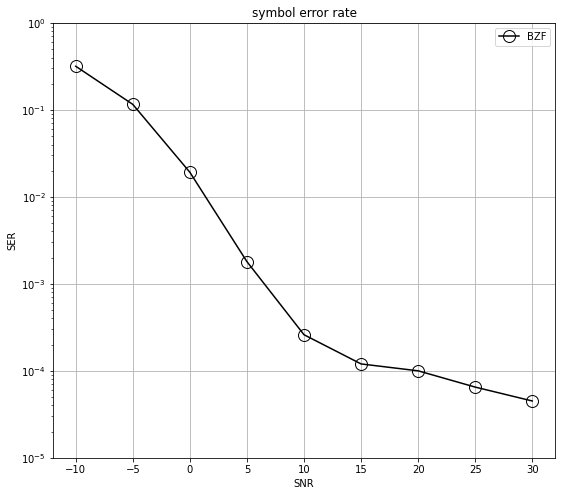

In [5]:
save_dir = './results/'
hparam_config = dict() 
hparam_config["K"] = 2
hparam_config["N"] = 16
hparam_config["M"] = 4 
hparam_config["T"] = int(1e4)
hparam_config["snr_min"] = -10
hparam_config["snr_max"] = 30
hparam_config["estimator"] = zf
hparam_config["detector"] = symbol_by_symbol
bzf_receiver = BussgangReceiver(hparam_config=hparam_config)

sers_avg_zf = np.zeros_like(bzf_receiver.snr_list, dtype=np.float64)
sers_avg_zf += bzf_receiver.run(trials=10, verbose=2) 

np.save(save_dir + 'sers_avg_bzf.npy', sers_avg_zf[:-1])

plt.figure(figsize=(9, 8))
plt.semilogy(bzf_receiver.snr_list, sers_avg_zf, '-ko', label='BZF', markersize=12, fillstyle='none')

plt.grid()
plt.legend()
plt.xlabel("SNR")
plt.ylabel("SER")
plt.title("symbol error rate")
plt.yticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
plt.show()
    

In [6]:
def symbol_by_symbol(x_tilde, constellation_points):
    """
    symbol-by-symbol detection with respect to each antenna: 
    can be used when relaxation and estimation is preceded (1-bit-ADC case) 
    """
    compare = np.abs(x_tilde - constellation_points)
    det_by_idx = np.argmin(compare, axis=-1)
    x_hat = np.take(constellation_points, det_by_idx).reshape(x_tilde.shape)
    return x_hat

In [284]:
def ml(y_re, H_re, symbol_space, snr_dB):
    """
    Maximum Likelihood detection for KxN mu-MIMO channel (uses Gaussian distribution) 
    """
    # complex to real and then reshape for broadcast
    snr = 10**(snr_dB/20)
    T = H_re.shape[0]
    K = H_re.shape[-1] // 2
    M = int(symbol_space.shape[0] ** (1/K))
    x_shape = tuple([T, K, 1])
    symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))
    likelihood = phi(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
    log_likelihood = np.sum(np.log(likelihood), axis=2)

    x_hat_idx = np.argmax(log_likelihood, axis=1)
    x_hat_ML = np.take(symbol_space, x_hat_idx, axis=0)
    x_hat_ML = x_hat_ML.reshape(x_shape)
    return x_hat_ML 

def two_stage_detect(y, H, symbol_space, snr_dB):
    snr = 10 ** (snr_dB/20)
    T = H.shape[0]
    K = H.shape[-1] // 2
    x_hat_ML = []
    for t in range(T):
        symbol_space_re = np.hstack((symbol_space[1][t].real, symbol_space[1][t].imag))
        likelihood = phi(np.matmul(symbol_space_re, H[t].T) * y[t].T * np.sqrt(2 * snr))
        log_likelihood = np.sum(np.log(likelihood), axis=1)
        x_hat_ML.append(symbol_space[1][t][np.argmax(log_likelihood)])
    x_hat_ML = np.array(x_hat_ML)
    return x_hat_ML


def initialize(G_tilde, y_re):
    num1 = np.matmul(G_tilde.transpose(0, 2, 1), np.ones_like(y_re))
    denom1 = np.linalg.norm(num1, axis=1).reshape(-1, 1, 1)
    x_init = (num1 / denom1) * np.sqrt(K)
    return x_init

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

def initialize(G_tilde, y_re):
    num1 = np.matmul(G_tilde.transpose(0, 2, 1), np.ones_like(y_re))
    denom1 = np.linalg.norm(num1, axis=1).reshape(-1, 1, 1)
    x_init = (num1 / denom1) * np.sqrt(K)
    return x_init

def sigmoid(t, c=1.702):
    return (1 / (1 + np.exp(-1 * c * t)))

def softplus(t):
    return np.log(1 + np.exp(t))

def robust_ml(y_re, H_re, symbol_space, snr_dB):
    """
    robust Maximum Likelihood detection for KxN mu-MIMO channel (uses sigmoid instead of Normal Distribution) 
    """
    # complex to real and then reshape for broadcast
    snr = 10**(snr_dB/20)   # convert dB scale to normal scale 

    # get informations from the channel matrix 
    T = H_re.shape[0]
    K = H_re.shape[-1] // 2
    M = int(symbol_space.shape[0] ** (1/K))
    x_shape = tuple([T, K, 1])

    # real representation of symbol_space 
    symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))

    # Compute the Log-likelihood 
    likelihood = sigmoid(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
    log_likelihood = np.sum(np.log(likelihood), axis=2)

    # pick symbol from the symbol space which maximizes the Likelihood 
    x_hat_idx = np.argmax(log_likelihood, axis=1)
    x_hat_rML = np.take(symbol_space, x_hat_idx, axis=0)
    x_hat_rML = x_hat_rML.reshape(x_shape)
    return x_hat_rML 

def initialize(G_tilde, y_re):
    num1 = np.matmul(G_tilde.transpose(0, 2, 1), np.ones_like(y_re))
    denom1 = np.linalg.norm(num1, axis=1).reshape(-1, 1, 1)
    x_init = (num1 / denom1) * np.sqrt(K)
    return x_init


def cost(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    g = np.sqrt(2 * snr) * (G_tilde @ x_init) 
    g = softplus(g) 
    g = np.log(g) 
    g = np.sum(g, axis=1) 
    return g

def compute_gradient(G_tilde, x_init, snr):
    c = 1.702
    snr = 10 ** (snr/20) 
    grad = np.sqrt(2 * snr) * np.matmul(G_tilde, x_init)
    grad = sigmoid(-grad)
    grad = np.matmul(G_tilde.transpose(0, 2, 1), grad)
    grad = -1 * c * np.sqrt(2 * snr) * grad
    return grad

def GD(x_init, snr, G_tilde, epoch=100, lr=0.1):
    global K
    costs = []
    for e in range(epoch):
        # print(x_init[0].squeeze(), '-->', end=' ')
        x_init -= lr * compute_gradient(G_tilde=G_tilde, x_init=x_init, snr=snr)
        # print(x_init[0].squeeze())
        if np.linalg.norm(x_init) >= np.sqrt(K):
            x_init /= np.linalg.norm(x_init, axis=1).reshape(-1, 1, 1)
            x_init *= np.sqrt(K)
        costs.append(cost(G_tilde=G_tilde, x_init=x_init, snr=snr))
        # if e % 1 == 0 : 
            # print(f"epoch {e}: descent_r=", np.around(compute_gradient(G_tilde=G_tilde, x_init=x_init, snr=snr).squeeze(), 2))
            # print(f"epoch {e}: descent_c=", np.around(compute_gradient_c(G_tilde=G_tilde, x_init=x_init, snr=snr).squeeze(), 2))
            # print(f"epoch {e}: cost=", np.around(cost(G_tilde=G_tilde, x_init=x_init, snr=snr).squeeze(), 2))
            # print(f"epoch {e}: cost=", np.around(cost_c(G_tilde=G_tilde, x_init=x_init, snr=snr).squeeze(), 2))
    return costs, x_init


def nML_robust(H_re, y_re, epoch=10, lr=0.001):
    """
    near maximum likelihood method (first stage)
    """
    global snr
    G_tilde = H_re * y_re 
    x_init = initialize(G_tilde=G_tilde, y_re=y_re)
    _, x_tilde_re = GD(x_init=x_init, snr=snr, epoch=epoch, lr=lr, G_tilde=G_tilde)
    x_tilde = x_tilde_re[:, :K, :] + 1j * x_tilde_re[:, K:, :]
    return x_tilde 

In [320]:
trials = 200
K = 2; N = 16; T = 5000; M = 4

snr_min = -10 
snr_max = 25
snr_lst = np.arange(snr_min, snr_max+1, 5)

constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

symbol_space = make_symbol_space(K, M, constellation_points) 
symbol_space = make_symbol_space(M=M, K=K, constellation_points=constellation_points)

sers_avg = np.zeros(shape=(len(snr_lst), 3)) 
x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)



for t in range(trials):
    print(f"Trial #{t}: process bar ==>", end=' ')
    sers = []
    for snr in snr_lst:
        print("==", end='')

        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z  

        # 1-bit ADC 
        y = np.sign(r.real) + 1j * np.sign(r.imag) 

        H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

        # near ML estimation(functional)
        G_tilde = H_re * y_re 
        x_init = initialize(G_tilde=G_tilde, y_re=y_re) 
        x_tilde = nML_robust(H_re, y_re, epoch=30, lr=0.003)

        # One-Stage method 
        x_det_first_stage = symbol_by_symbol(x_tilde=x_tilde, constellation_points=constellation_points)

        # Two-Stage method
        sym_space = two_nML(x_tilde, constellation_points)
        x_det_second_stage = two_stage_detect(y_re, H_re, symbol_space=sym_space, snr_dB=snr)

        x_det_ml = ml(y_re, H_re, symbol_space=symbol_space, snr_dB=snr) 
        
        ser_one_stage = 1 - (np.sum(np.isclose(x_det_first_stage.reshape(T, K, 1), x)) / (T*K))
        ser_two_stage = 1 - (np.sum(np.isclose(x_det_second_stage.reshape(T, K, 1), x)) / (T*K)) 
        ser_ml = 1 - (np.sum(np.isclose(x_det_ml.reshape(T, K, 1), x)) / (T*K))
        sers.append([ser_one_stage, ser_two_stage, ser_ml])
    print()
        
    sers = np.array(sers)
    sers_avg += sers     

sers_avg /= trials
print(sers_avg)



Trial #0: process bar ==> ========

/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


====

/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


====
Trial #1: process bar ==> ================
Trial #2: process bar ==> ================
Trial #3: process bar ==> ================

KeyboardInterrupt: 

In [317]:
ser_avg_temp = sers_avg

sers_avg = (ser_avg_temp * 100) + (sers_avg * 10) 
sers_avg /= 110 

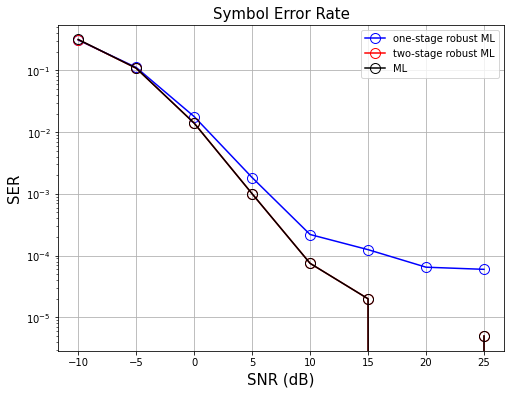

In [318]:
plt.figure(figsize=(8, 6)) 
plt.semilogy(snr_lst, sers_avg[:, 0], '-bo', label='one-stage robust ML', fillstyle='none', markersize=10) 
plt.semilogy(snr_lst, sers_avg[:, 1], '-ro', label='two-stage robust ML', fillstyle='none', markersize=10)
plt.semilogy(snr_lst, sers_avg[:, 2], '-ko', label='ML', fillstyle='none', markersize=10)
plt.legend() 
plt.xlabel("SNR (dB)", fontsize=15) 
plt.ylabel("SER", fontsize=15) 
plt.title("Symbol Error Rate", fontsize=15) 
plt.grid() 
plt.show() 

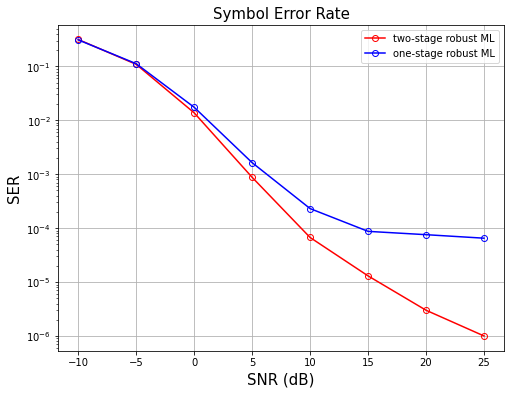

In [299]:
plt.figure(figsize=(8, 6)) 
plt.semilogy(snr_lst, sers_avg_two_stage, '-ro', label='two-stage robust ML', fillstyle='none')
plt.semilogy(snr_lst, sers_avg, '-bo', label='one-stage robust ML', fillstyle='none') 
plt.legend() 
plt.xlabel("SNR (dB)", fontsize=15) 
plt.ylabel("SER", fontsize=15) 
plt.title("Symbol Error Rate", fontsize=15) 
plt.grid() 
plt.show() 

In [ ]:
G == np.diag(y_re[0].squeeze()) @ H_re[0] 

NameError: name 'G' is not defined

# Making nearest ML search for T trials 

In [222]:
from itertools import product


def two_nML(x_tilde, constellation_points, c=2):
    T = len(x_tilde)
    K = len(x_tilde[0])
    x_est = x_tilde 
    x_det = symbol_by_symbol(x_est, constellation_points)
    x_ex = constellation_points.squeeze() 

    num = np.abs(x_est - x_ex) 
    den = np.abs(x_est - x_det)
    cond = (num / den) < c 

    setsize_t = np.sum(cond, axis=2) 
    nn_t = [[[] for k in range(K)] for t in range(T)]
    for cond in np.argwhere(cond):
        nn_t[cond[0]][cond[1]].append(cond[2])

    new_symspace = [[] for _ in range(T)]
    new_symspace = []
    new_symspace_idx = []
    for e, trial in enumerate(nn_t):
        sym_space = [] 
        for element in product(*trial):
            sym_space.append(element)
        new_symspace.append(np.take(constellation_points, sym_space))
        new_symspace_idx.append(sym_space)
    return new_symspace_idx, new_symspace 



new_symspace_t = two_nML(x_tilde, constellation_points, c=2)

new_symspace_t[:10]
# for m, k in np.argwhere(condition):
#     nn[k].append(m)


# new_symbol_space = []
# new_symspace_t = [[] for _ in range(T)]
# for n in nn: 
#     new_symbol_space.append(list(np.take(constellation_points, n)))

# for e, trial in enumerate(nn_t): 
#     symbol_space_trial = []
#     for n in trial:
#         new_symspace_t[e].append(np.take(constellation_points, n))

# sym_space_per_trial = [] 
# for e, trial in enumerate(nn_t):
#     sym_space = []
#     for element in product(*trial):
#         sym_space.append((element))
#     sym_space_per_trial.append(np.array(sym_space))



# print(new_symbol_space)

([[(2, 3), (3, 3)],
  [(3, 2)],
  [(3, 0)],
  [(1, 2)],
  [(1, 3)],
  [(0, 0)],
  [(3, 2)],
  [(2, 0), (2, 2)],
  [(0, 3)],
  [(1, 2)]],
 [array([[0.70710678-0.70710678j, 0.70710678+0.70710678j],
         [0.70710678+0.70710678j, 0.70710678+0.70710678j]]),
  array([[0.70710678+0.70710678j, 0.70710678-0.70710678j]]),
  array([[ 0.70710678+0.70710678j, -0.70710678-0.70710678j]]),
  array([[-0.70710678+0.70710678j,  0.70710678-0.70710678j]]),
  array([[-0.70710678+0.70710678j,  0.70710678+0.70710678j]]),
  array([[-0.70710678-0.70710678j, -0.70710678-0.70710678j]]),
  array([[0.70710678+0.70710678j, 0.70710678-0.70710678j]]),
  array([[ 0.70710678-0.70710678j, -0.70710678-0.70710678j],
         [ 0.70710678-0.70710678j,  0.70710678-0.70710678j]]),
  array([[-0.70710678-0.70710678j,  0.70710678+0.70710678j]]),
  array([[-0.70710678+0.70710678j,  0.70710678-0.70710678j]])])

In [139]:
make_symbol_space(M=4, K=2, constellation_points=constellation_points)


array([[-0.70710678-0.70710678j, -0.70710678-0.70710678j],
       [-0.70710678-0.70710678j, -0.70710678+0.70710678j],
       [-0.70710678-0.70710678j,  0.70710678-0.70710678j],
       [-0.70710678-0.70710678j,  0.70710678+0.70710678j],
       [-0.70710678+0.70710678j, -0.70710678-0.70710678j],
       [-0.70710678+0.70710678j, -0.70710678+0.70710678j],
       [-0.70710678+0.70710678j,  0.70710678-0.70710678j],
       [-0.70710678+0.70710678j,  0.70710678+0.70710678j],
       [ 0.70710678-0.70710678j, -0.70710678-0.70710678j],
       [ 0.70710678-0.70710678j, -0.70710678+0.70710678j],
       [ 0.70710678-0.70710678j,  0.70710678-0.70710678j],
       [ 0.70710678-0.70710678j,  0.70710678+0.70710678j],
       [ 0.70710678+0.70710678j, -0.70710678-0.70710678j],
       [ 0.70710678+0.70710678j, -0.70710678+0.70710678j],
       [ 0.70710678+0.70710678j,  0.70710678-0.70710678j],
       [ 0.70710678+0.70710678j,  0.70710678+0.70710678j]])